<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Exercise_3_GNN_for_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two moons with an invertible Neural Network

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

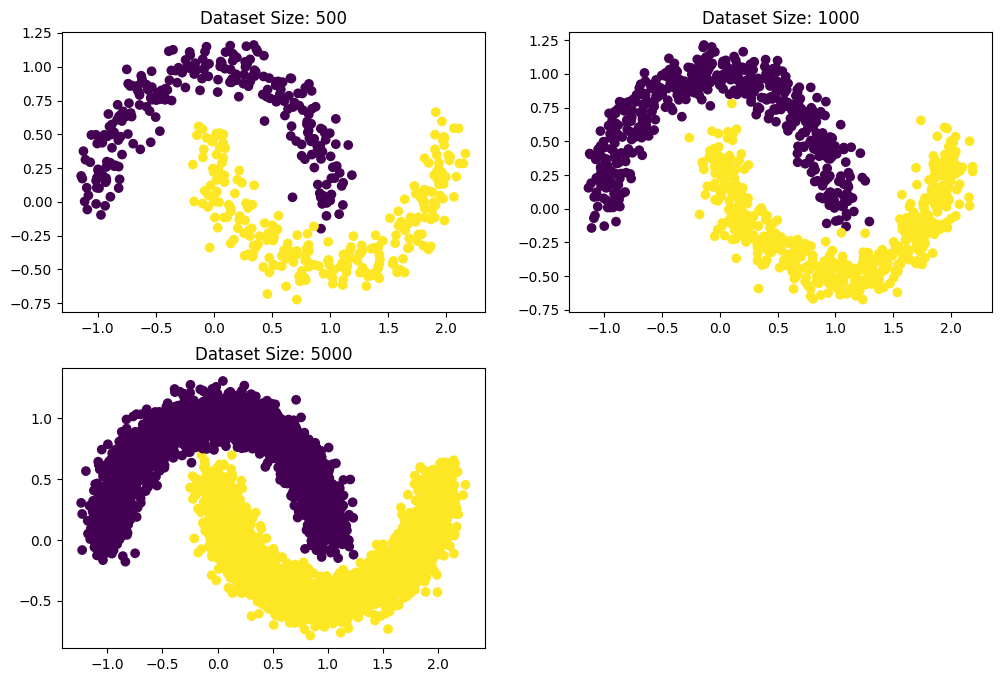

In [3]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()


In [4]:
# input_size = 2
# hidden_size = 256
# blocks = 8

# realnvp_model = RealNVP(input_size, hidden_size, blocks)

# # forward pass (encoding)
# input_data = torch.randn(1, input_size)
# encoded_data = realnvp_model.encode(input_data)

# # reverse pass (decoding)
# decoded_data = realnvp_model.decode(encoded_data)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x):
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling = torch.exp(torch.tanh(self.fc4(h)))

        # Apply the affine transformation
        y_a = x_a + translation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([y_a, y_b], dim=1)
        return y

    def backward(self, y):
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling = torch.exp(torch.tanh(self.fc4(h)))

        # Reverse the operations to reconstruct the original input
        x_a = y_a - translation
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])

        # List of random orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]

    def _get_orthonormal_matrix(self, size):
        # Function to generate a random orthonormal matrix
        w = torch.randn(size, size)
        q, _ = torch.qr(w)
        return q

    def forward_realnvp(self, x):
        for i in range(self.blocks):
            # Apply random orthonormal matrix
            x = x @ self.orthonormal_matrices[i]
            # Apply coupling layer
            x = self.coupling_layers[i](x)
        return x

    def encode(self, x):
        # Encoding is the forward pass through the RealNVP model
        return self.forward_realnvp(x)

    def decode(self, z):
        # Reverse transformations for decoding
        for i in reversed(range(self.blocks)):
            # Apply random orthonormal matrix (reverse)
            z = z @ self.orthonormal_matrices[i].t()
            # Apply coupling layer (reverse)
            z = self.coupling_layers[i].backward(z)
        return z


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_inn(model, train_loader, num_epochs=10, lr=0.001):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        total_loss = 0.0

        # Iterate over the training dataset
        for data in train_loader:
            inputs, _ = data  # Assuming the dataset provides both inputs and labels

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.encode(inputs)

            # Loss calculation (leave this part empty for now)
            loss = calculate_loss(encoded, inputs)

            # Backward pass (gradient computation)
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item()

        # Print average loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    print("Training complete")

def calculate_loss(output, target):
    # Implement your loss function here
    # For example, you can use negative log-likelihood loss
    # (criterion = nn.NLLLoss() and criterion(output, target))
    pass
